# PCA on SST Data (ENSO Analysis)

In [1]:
from __future__ import division

%matplotlib inline

from IPython.display import display 
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import peakutils
import scipy.io as sio
import scipy.signal
import sys
import xarray as xr

sys.path.append('../src/')
import utils

mpl.rcParams['legend.fontsize'] = 'small'

## Load data

In [2]:
datafile = 'SST_ERAInterim_monthly_Jan1979_Jun2017_Tropical_Pacific.nc'
with xr.open_dataset(datafile) as ds:
    ds.load()
ds.rename({'latitude' : 'lat', 'longitude' : 'lon'}, inplace=True)
ds

<xarray.Dataset>
Dimensions:  (lat: 29, lon: 135, time: 462)
Coordinates:
  * lat      (lat) float32 10.5 9.75 9.0 8.25 7.5 6.75 6.0 5.25 4.5 3.75 3.0 ...
  * lon      (lon) float32 159.75 160.5 161.25 162.0 162.75 163.5 164.25 ...
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 1979-03-01 ...
Data variables:
    sst      (time, lat, lon) float64 300.9 300.9 300.9 300.9 300.8 300.8 ...
Attributes:
    Conventions:  CF-1.6
    history:      2017-09-25 20:57:48 GMT by grib_to_netcdf-2.4.0: grib_to_ne...

In [3]:
coast_in = sio.loadmat('coastline.mat')
arr = np.concatenate((coast_in['long'], coast_in['lat']), axis=1)
coast = pd.DataFrame(arr, columns=['lon', 'lat'])
coast.head()

,lon,lat
0,-180.0,-83.83
1,-178.0,-84.33
2,-174.0,-84.50
3,-170.0,-84.67
4,-166.0,-84.92


## Helper functions

In [4]:
def stack_latlon(var_in, inverse=False):
    if inverse:
        var_out = var_in.unstack('pt')
    else:
        var_out = var_in.stack(pt=('lat', 'lon'))
    return var_out

def stack_time(var_in, inverse=False):    
    if inverse:
        dims = list(var_in.dims)
        dims.remove('time')
        dims = ['year', 'month'] + dims
        var_out = var_in.unstack('time').transpose(*dims)
    else:
        var_out = var_in.stack(time=['year', 'month'])
        dims = list(var_out.dims)
        dims.remove('time')
        dims = ['time'] + dims
        var_out = var_out.transpose(*dims)
    return var_out            

def monthly_climatology(var_in):
    var_out = stack_time(var_in, inverse=True)
    return var_out.mean(dim='year')

def plot_coast(coast, fmt='k'):
    plt.plot(coast['lon'], coast['lat'], fmt)
    plt.plot(coast['lon'] + 360, coast['lat'], fmt)

def plot_var(var_in, coast=None,  cmap='jet', colorbar=True):
    # First check if the lat-lon gridpoints need to be unstacked
    if 'lat' not in var_in.dims:
        var_in = stack_latlon(var_in, inverse=True)
    vals = np.ma.masked_array(var_in, np.isnan(var_in))
    plt.pcolormesh(var_in['lon'], var_in['lat'], vals, cmap=cmap)
    if coast is not None:
        plot_coast(coast)
    if colorbar:
        plt.colorbar()

## Wrangling data and dimensions

In [9]:
#  Variable we're looking at is SST in deg C
var = ds['sst'] - 273.15

# Let's add the years and months as a multi-index to make life easier
var.coords['year'] = var['time'].dt.year
var.coords['month'] = var['time'].dt.month
var.coords['timevec'] = var['year'] + (var['month'] - 1)/12.0
var = var.set_index(time=['year', 'month'])

# Remove the partial year 2017
yrmax = 2016
ykeep = var['year'] <= 2016
var = var[ykeep]
var

<xarray.DataArray 'sst' (time: 456, lat: 29, lon: 135)>
array([[[ 27.793655,  27.761807, ...,  27.259719,  27.122769],
        [ 28.002546,  27.938661, ...,  27.126704,  27.019354],
        ..., 
        [ 28.935904,        nan, ...,  24.290286,  24.288037],
        [ 29.268443,  29.11332 , ...,  24.241014,  24.217408]],

       [[ 27.471046,  27.438822, ...,  27.170543,  27.137008],
        [ 27.704479,  27.664199, ...,  27.009238,  26.993501],
        ..., 
        [ 28.76673 ,        nan, ...,  25.368649,  25.316567],
        [ 29.023394,  28.875953, ...,  25.288278,  25.225517]],

       ..., 
       [[ 29.640699,  29.568196, ...,  27.94578 ,  27.79684 ],
        [ 29.801629,  29.723506, ...,  27.873839,  27.776045],
        ..., 
        [ 29.198188,        nan, ...,  23.646565,  23.553829],
        [ 29.373919,  29.249708, ...,  23.649   ,  23.570128]],

       [[ 28.734507,  28.745186, ...,  27.600314,  27.414467],
        [ 28.868085,  28.851036, ...,  27.232554,  27.140755],
 

In [10]:
# Data with lat-lon dimensions stacked, for PCA
var_stk = stack_latlon(var)
var_stk

<xarray.DataArray 'sst' (time: 456, pt: 3915)>
array([[ 27.793655,  27.761807,  27.729958, ...,  24.306959,  24.241014,
         24.217408],
       [ 27.471046,  27.438822,  27.392922, ...,  25.371834,  25.288278,
         25.225517],
       [ 27.61755 ,  27.630477,  27.627667, ...,  25.723295,  25.661096,
         25.642924],
       ..., 
       [ 29.948883,  29.929774,  29.848091, ...,  23.583242,  23.486197,
         23.409572],
       [ 29.640699,  29.568196,  29.415697, ...,  23.731433,  23.649   ,
         23.570128],
       [ 28.734507,  28.745186,  28.737692, ...,  23.923462,  23.76553 ,
         23.762907]])
Coordinates:
  * time     (time) MultiIndex
  - year     (time) int64 1979 1979 1979 1979 1979 1979 1979 1979 1979 1979 ...
  - month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 ...
    timevec  (time) float64 1.979e+03 1.979e+03 1.979e+03 1.979e+03 ...
  * pt       (pt) MultiIndex
  - lat      (pt) float64 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.

## Plot input data

(-50, 50)

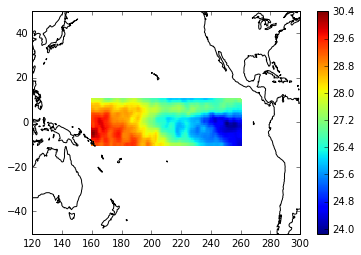

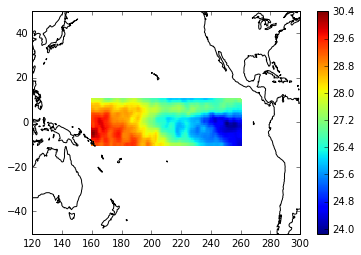

In [11]:
# Plot the first month of data
plot_var(var[0], coast=coast)
plt.xlim(120, 300)
plt.ylim(-50, 50)

# And same thing for the latlon stacked data
plt.figure()
plot_var(var_stk[0], coast=coast)
plt.xlim(120, 300)
plt.ylim(-50, 50)

In [12]:
def plot_year(var, year, climits=None, coast=None, figsize=(14, 10)):
    nr, nc = 3, 4
    fig, axes = plt.subplots(nr, nc, figsize=figsize, sharex='all', sharey='all')
    axes = axes.ravel()
    var_yr = var.sel(year=year)
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, mon in enumerate(months):
        plt.sca(axes[i])
        plt.gca().autoscale(tight=True)
        plot_var(var_yr[i], coast=coast, colorbar=False)
        if climits is not None:
            plt.clim(climits)
        plt.title(mon + ' %d' % year)
        if i == len(months) - 1:
            plt.colorbar()

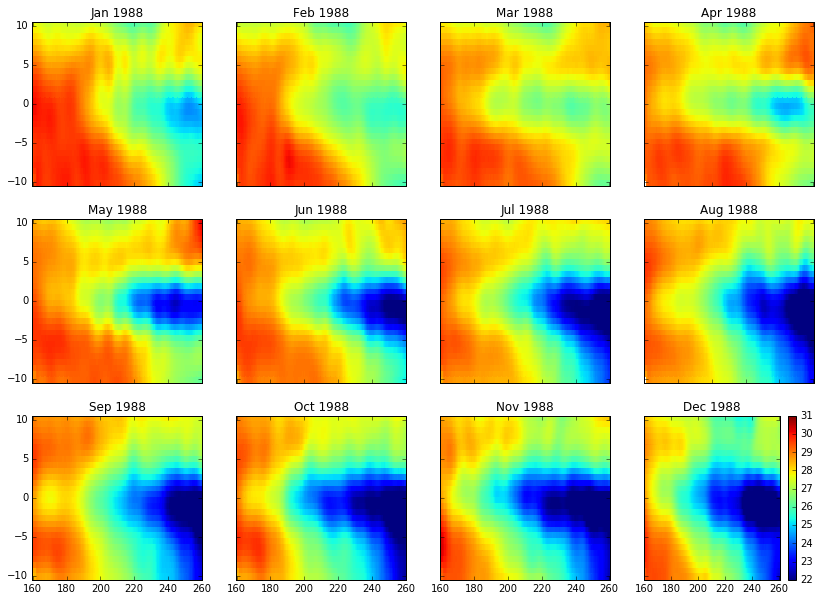

In [13]:
# Plot each month during 1988 (strong La Nina event)
year = 1988
plot_year(var_stk, year, climits=(22, 31))

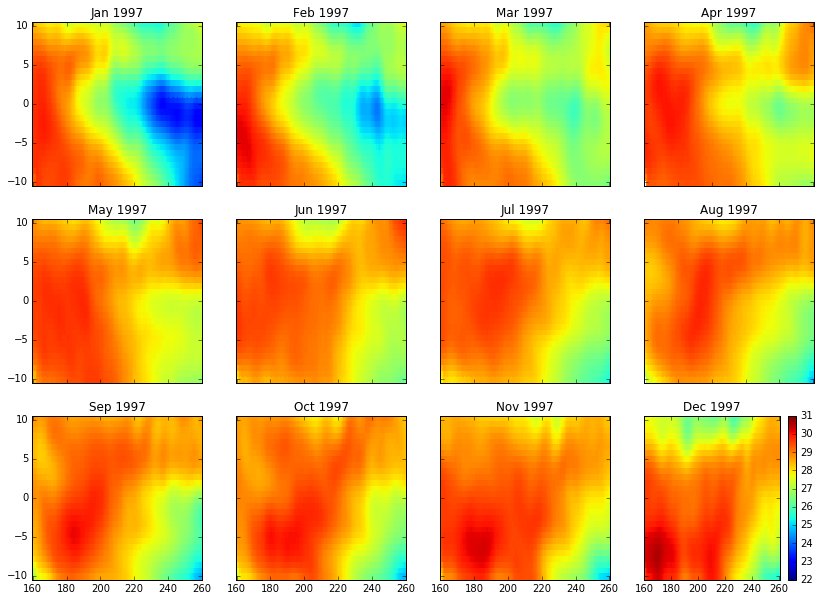

In [14]:
# Plot each month during 1997 (strong El Nino event)
year = 1997
plot_year(var_stk, year, climits=(22, 31))

## Pre-processing for PCA

In [15]:
# Compute the climatology and tile it for all the years
var_seasonal = monthly_climatology(var_stk)
nyears = int(len(var_stk['time']) / 12)
var_seasonal = np.tile(var_seasonal, (nyears, 1))
var_seasonal = xr.DataArray(var_seasonal, dims=var_stk.dims, coords=var_stk.coords)
var_seasonal

<xarray.DataArray (time: 456, pt: 3915)>
array([[ 27.86569 ,  27.842765,  27.809767, ...,  24.198175,  24.130899,
         24.099572],
       [ 27.613498,  27.591351,  27.560464, ...,  25.339665,  25.299208,
         25.290023],
       [ 27.772298,  27.759504,  27.744492, ...,  26.191073,  26.177032,
         26.191404],
       ..., 
       [ 29.341034,  29.329306,  29.305271, ...,  23.061242,  22.932392,
         22.813309],
       [ 28.994139,  28.980837,  28.957858, ...,  23.11182 ,  22.980525,
         22.869508],
       [ 28.378983,  28.366579,  28.344709, ...,  23.454673,  23.350677,
         23.272672]])
Coordinates:
  * time     (time) MultiIndex
  - year     (time) int64 1979 1979 1979 1979 1979 1979 1979 1979 1979 1979 ...
  - month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 ...
    timevec  (time) float64 1.979e+03 1.979e+03 1.979e+03 1.979e+03 ...
  * pt       (pt) MultiIndex
  - lat      (pt) float64 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5

In [16]:
# Remove the climatological seasonal cycle
var_anom = var_stk - var_seasonal
var_anom

<xarray.DataArray (time: 456, pt: 3915)>
array([[-0.072035, -0.080958, -0.079809, ...,  0.108784,  0.110115,  0.117836],
       [-0.142452, -0.152529, -0.167542, ...,  0.032169, -0.01093 , -0.064506],
       [-0.154748, -0.129027, -0.116825, ..., -0.467778, -0.515936, -0.54848 ],
       ..., 
       [ 0.607849,  0.600468,  0.54282 , ...,  0.522   ,  0.553805,  0.596263],
       [ 0.646561,  0.587359,  0.457839, ...,  0.619612,  0.668475,  0.70062 ],
       [ 0.355523,  0.378606,  0.392983, ...,  0.468789,  0.414853,  0.490235]])
Coordinates:
  * time     (time) MultiIndex
  - year     (time) int64 1979 1979 1979 1979 1979 1979 1979 1979 1979 1979 ...
  - month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 ...
    timevec  (time) float64 1.979e+03 1.979e+03 1.979e+03 1.979e+03 ...
  * pt       (pt) MultiIndex
  - lat      (pt) float64 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 ...
  - lon      (pt) float64 159.8 160.5 161.2 162.0 162.8 163.5 164.2 165.0 ...

In [17]:
# Apply 3-month running mean
window = 3
var_anom_sm = var_anom.rolling(time=window, center=True).mean()
var_anom_sm

<xarray.DataArray (time: 456, pt: 3915)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [-0.123078, -0.120838, -0.121392, ..., -0.108942, -0.138917, -0.16505 ],
       [-0.173293, -0.169451, -0.17073 , ..., -0.30162 , -0.338302, -0.370237],
       ..., 
       [ 0.663938,  0.660947,  0.629259, ...,  0.536378,  0.550536,  0.579285],
       [ 0.536644,  0.522145,  0.464547, ...,  0.5368  ,  0.545711,  0.595706],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]])
Coordinates:
  * time     (time) MultiIndex
  - year     (time) int64 1979 1979 1979 1979 1979 1979 1979 1979 1979 1979 ...
  - month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 ...
    timevec  (time) float64 1.979e+03 1.979e+03 1.979e+03 1.979e+03 ...
  * pt       (pt) MultiIndex
  - lat      (pt) float64 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 ...
  - lon      (pt) float64 159.8 160.5 161.2 162.0 162.8 163.5 164.2 165.0 ...

(-2, 2)

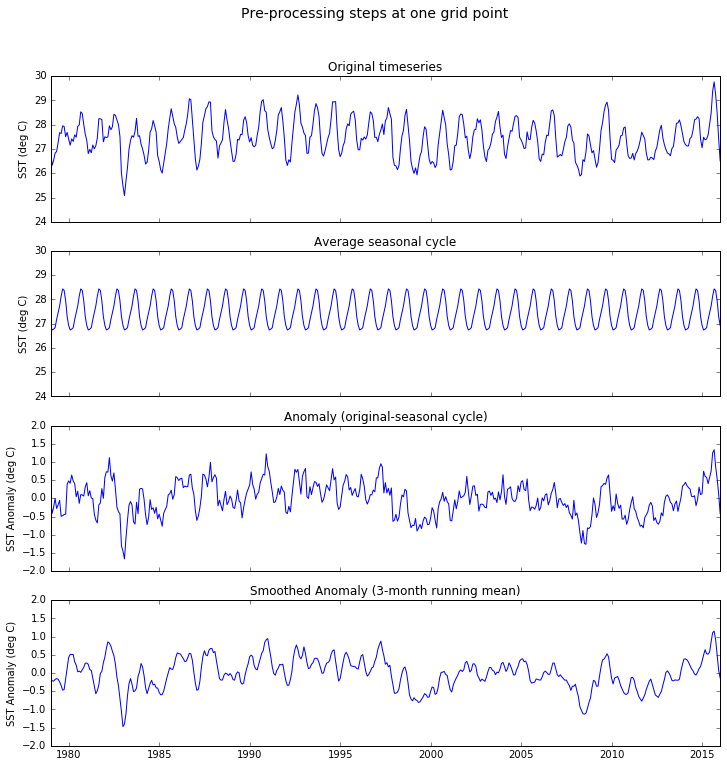

In [18]:
# Plot all the pre-processing steps for one grid point
ipt = 49
xlimits = var_stk['year'].min(), var_stk['year'].max()
timevec = var_stk['timevec']
nr, nc = 4, 1
fig, axes = plt.subplots(nr, nc, figsize=(12, 12), sharex='all')
axes = axes.ravel()
plt.suptitle('Pre-processing steps at one grid point', fontsize=14)
plt.sca(axes[0])
plt.plot(timevec, var_stk[:, ipt])
plt.xlim(xlimits)
plt.ylim(24, 30)
plt.title('Original timeseries')
plt.ylabel('SST (deg C)')

plt.sca(axes[1])
plt.plot(timevec, var_seasonal[:, ipt])
plt.title('Average seasonal cycle')
plt.ylabel('SST (deg C)')
plt.ylim(24, 30)

plt.sca(axes[2])
plt.plot(timevec, var_anom[:, ipt])
plt.title('Anomaly (original-seasonal cycle)')
plt.ylabel('SST Anomaly (deg C)')
plt.ylim(-2, 2)

plt.sca(axes[3])
plt.plot(timevec, var_anom_sm[:, ipt])
plt.title('Smoothed Anomaly (3-month running mean)')
plt.ylabel('SST Anomaly (deg C)')
plt.ylim(-2, 2)

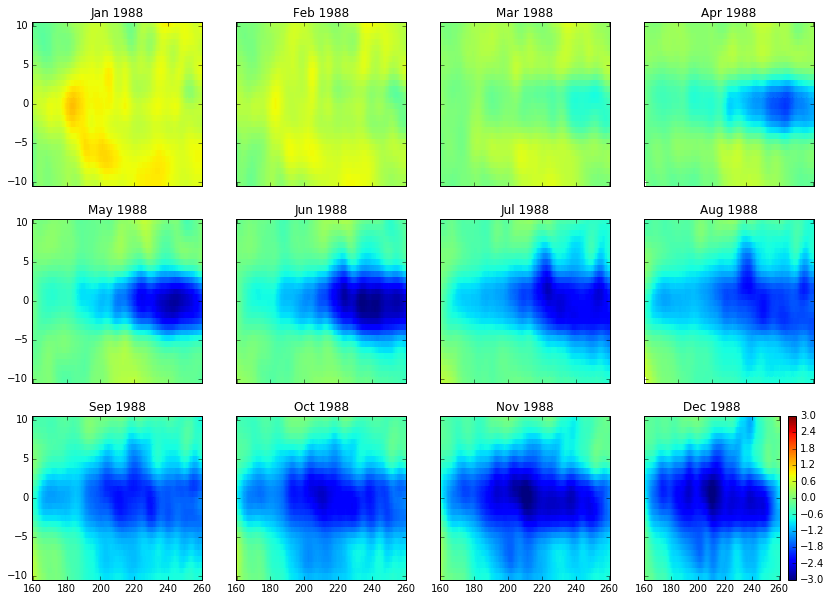

In [19]:
# plot the 3-month running mean of residuals for all grid points for all months of 1988
year = 1988
plot_year(var_anom_sm, year, climits=(-3, 3))

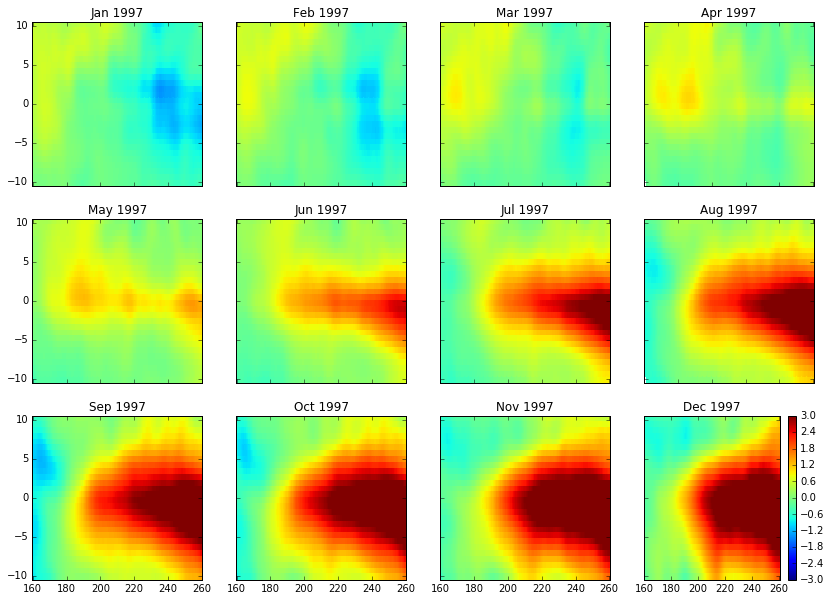

In [20]:
year = 1997
plot_year(var_anom_sm, year, climits=(-3, 3))

## PCA

In [21]:
# Rows are monthly measurements, columns are grid points
# Remove the first and last months (which are NaNs due to the 3-month rolling mean)
data = var_anom_sm[1:-1].copy()

# There's one grid point that's missing
ind = np.where(np.isnan(data))
print(set(ind[1]))

set([3646])


In [22]:
# Fill the missing grid point with a nearest neighbour
i0 = 3646
lat0 = data['lat'].values[i0]
lon0 = data['lon'].values[i0]
print(lat0, lon0)

vals = data.sel(lat=lat0).sel(lon=(lon0+0.75)).values
data[:, i0] = vals

(-9.75, 160.5)


(-50, 50)

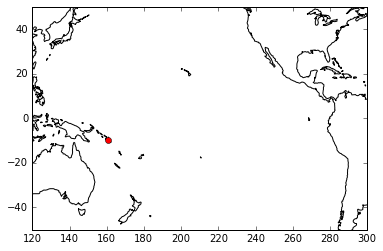

In [29]:
plt.plot(coast['lon'], coast['lat'], 'k')
plt.plot(coast['lon'] + 360, coast['lat'], 'k')
plt.plot(lon0, lat0, 'ro')
plt.xlim(120, 300)
plt.ylim(-50, 50)

In [205]:
kmax = 20
pca = utils.princomp(data, kmax=kmax)
eigval, eigvec, PCs = pca['eigval'], pca['eigvec'], pca['scores']

In [216]:
# Convert eigenvector matrix into xr.DataArray with metadata
coords = {'pt' : data['pt'], 'mode' : range(1, len(eigval) + 1)}
eigvec = xr.DataArray(eigvec, dims=['mode', 'pt'], coords=coords)
eigvec

<xarray.DataArray (mode: 20, pt: 3915)>
array([[-0.001978, -0.001789, -0.001622, ...,  0.006447,  0.006459,  0.006523],
       [-0.007914, -0.008377, -0.008829, ...,  0.015535,  0.015914,  0.016177],
       [-0.002478, -0.002207, -0.001756, ..., -0.034789, -0.035458, -0.035816],
       ..., 
       [ 0.001406,  0.003284,  0.003359, ...,  0.007042,  0.007479,  0.006478],
       [-0.023033, -0.021901, -0.020477, ...,  0.022794,  0.023318,  0.023065],
       [-0.008959, -0.011465, -0.011921, ..., -0.000325, -0.005605, -0.008432]])
Coordinates:
  * mode     (mode) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * pt       (pt) MultiIndex
  - lat      (pt) float64 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 10.5 ...
  - lon      (pt) float64 159.8 160.5 161.2 162.0 162.8 163.5 164.2 165.0 ...

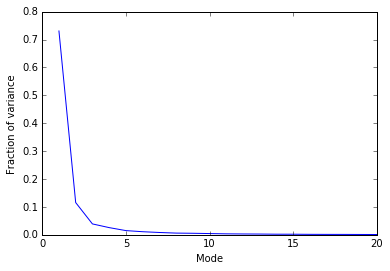

In [206]:
plt.plot(range(1, len(pca['varfrac']) + 1), pca['varfrac'])
plt.xlabel('Mode')
plt.ylabel('Fraction of variance')

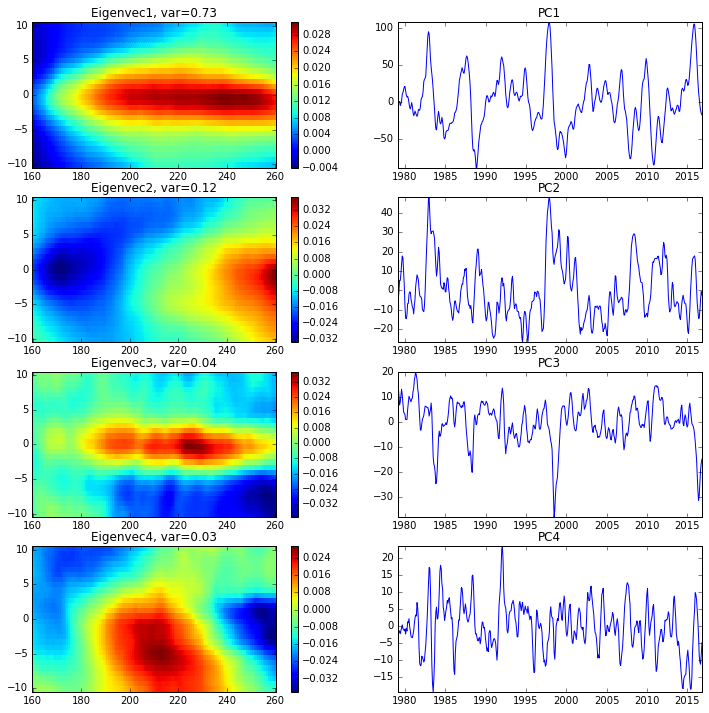

In [221]:
# Plot first 4 eigenvectors and PCs
nr, nc = 4, 2
iplot = 1
plt.figure(figsize=(12, 12))
for i in range(4):
    plt.subplot(nr, nc, iplot)
    plot_var(eigvec[i])
    plt.gca().autoscale(tight=True)
    plt.title('Eigenvec%d, var=%.2f' % (i + 1, pca['varfrac'][i]))
    iplot += 1
    plt.subplot(nr, nc, iplot)
    plt.plot(data['timevec'], PCs[:, i])
    plt.title('PC%d' % (i + 1))
    plt.gca().autoscale(tight=True)
    iplot += 1

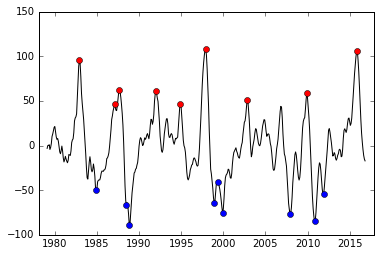

In [274]:
vec = PCs[:, 0]
min_dist = 3
inino = peakutils.indexes(vec, thres=0.68, min_dist=min_dist)
inina = peakutils.indexes(-vec, thres=0.75, min_dist=min_dist)

timevec = data['timevec']
plt.plot(timevec, vec, 'k')
plt.plot(timevec[inino], vec[inino], 'ro')
plt.plot(timevec[inina], vec[inina], 'bo')
plt.xlim(min(timevec)-1, max(timevec)+1);

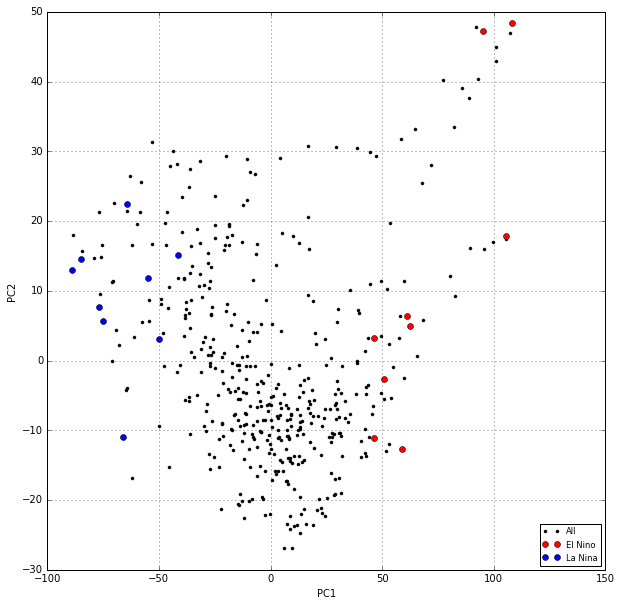

In [281]:
# plot data in space of the two first two PCs
plt.figure(figsize=(10, 10))
plt.plot(PCs[:, 0], PCs[:, 1], 'k.', label='All')
plt.plot(PCs[inino, 0], PCs[inino, 1], 'ro', markersize=6, label='El Nino')
plt.plot(PCs[inina, 0], PCs[inina, 1], 'bo', markersize=6, label='La Nina')
plt.legend(loc='lower right')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()